# pyfssa Tutorial

## Preamble

In [1]:
from __future__ import division

In [2]:
# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 12, \
                            'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline

In [3]:
import itertools

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
import fssa

## A mock scaling function

In this tutorial, we will demonstrate the *pyfssa* routines with a mock scaling function
\begin{equation}
\tilde{f}(x) = e^{-(x+1)^2}
\end{equation}

In [5]:
def mock_scaling_f(x):
    """Mock scaling function"""
    return np.exp(-(x + 1.0)**2)

In [6]:
x = np.linspace(-4.0, 2.0, num=200)

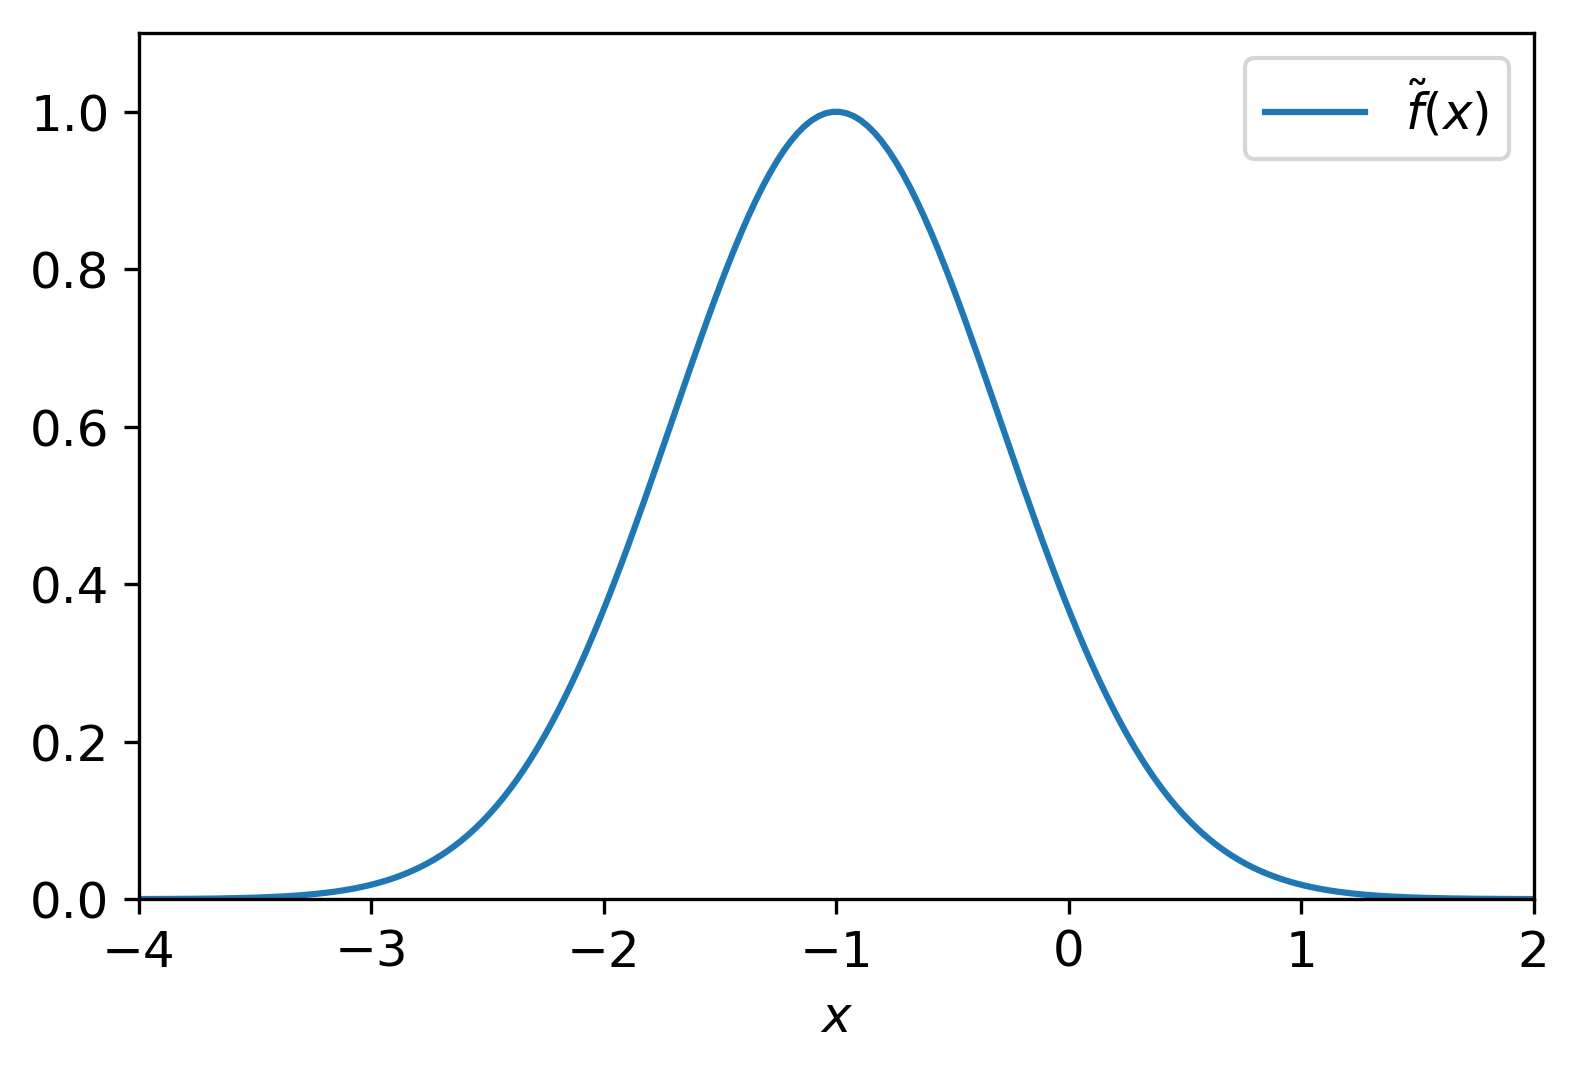

In [7]:
fig, ax = plt.subplots()
ax.plot(x, mock_scaling_f(x), label=r'$\tilde{f}(x)$', rasterized=True)
ax.set_xbound(x.min(), x.max())
ax.set_ybound(0.0, 1.1)
ax.set_xlabel(r'$x$')
ax.legend()
plt.show()

**Figure**: Mock scaling function $\tilde{f}(x) = e^{-(x+1)^2}$

## Precisely mocking scaled data

We generate mock observations $a_{L,\varrho}$ according to the finite-size scaling
\begin{equation}
a_{L, \varrho} = L^{\zeta/\nu} \tilde{f}\left(L^{1/\nu} (\varrho -
\varrho_c)\right)
\end{equation}
with mock exponents $\nu = \frac{5}{2}, \zeta=\frac{3}{2}$ and $\rho_c = \frac{1}{2}$.

In [8]:
def mock_scaled_data(l, rho, rho_c=0.5, nu=2.5, zeta=1.5):
    """Generate scaled data from mock scaling function"""
    return np.transpose(
        np.power(l, zeta / nu) *
        mock_scaling_f(
            np.outer(
                (rho - rho_c), np.power(l, 1 / nu)
            )
        )
    )

In [9]:
rhos = np.linspace(-0.5, 0.8, num=200)
ls = np.logspace(1, 3, num=5).astype(np.int)

In [10]:
# system sizes
ls

array([  10,   31,  100,  316, 1000])

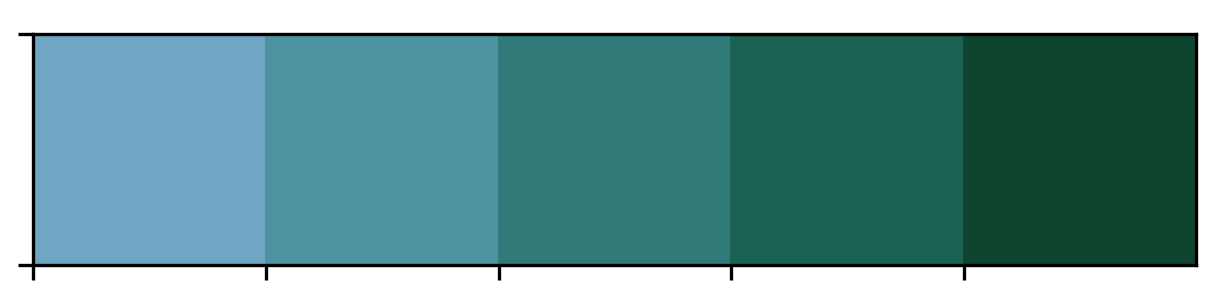

In [11]:
# Define colors
palette = sns.cubehelix_palette(
    n_colors=ls.size, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
)
sns.palplot(palette)

In [12]:
# Generate precisely mocked scaled data
a = mock_scaled_data(ls, rhos)

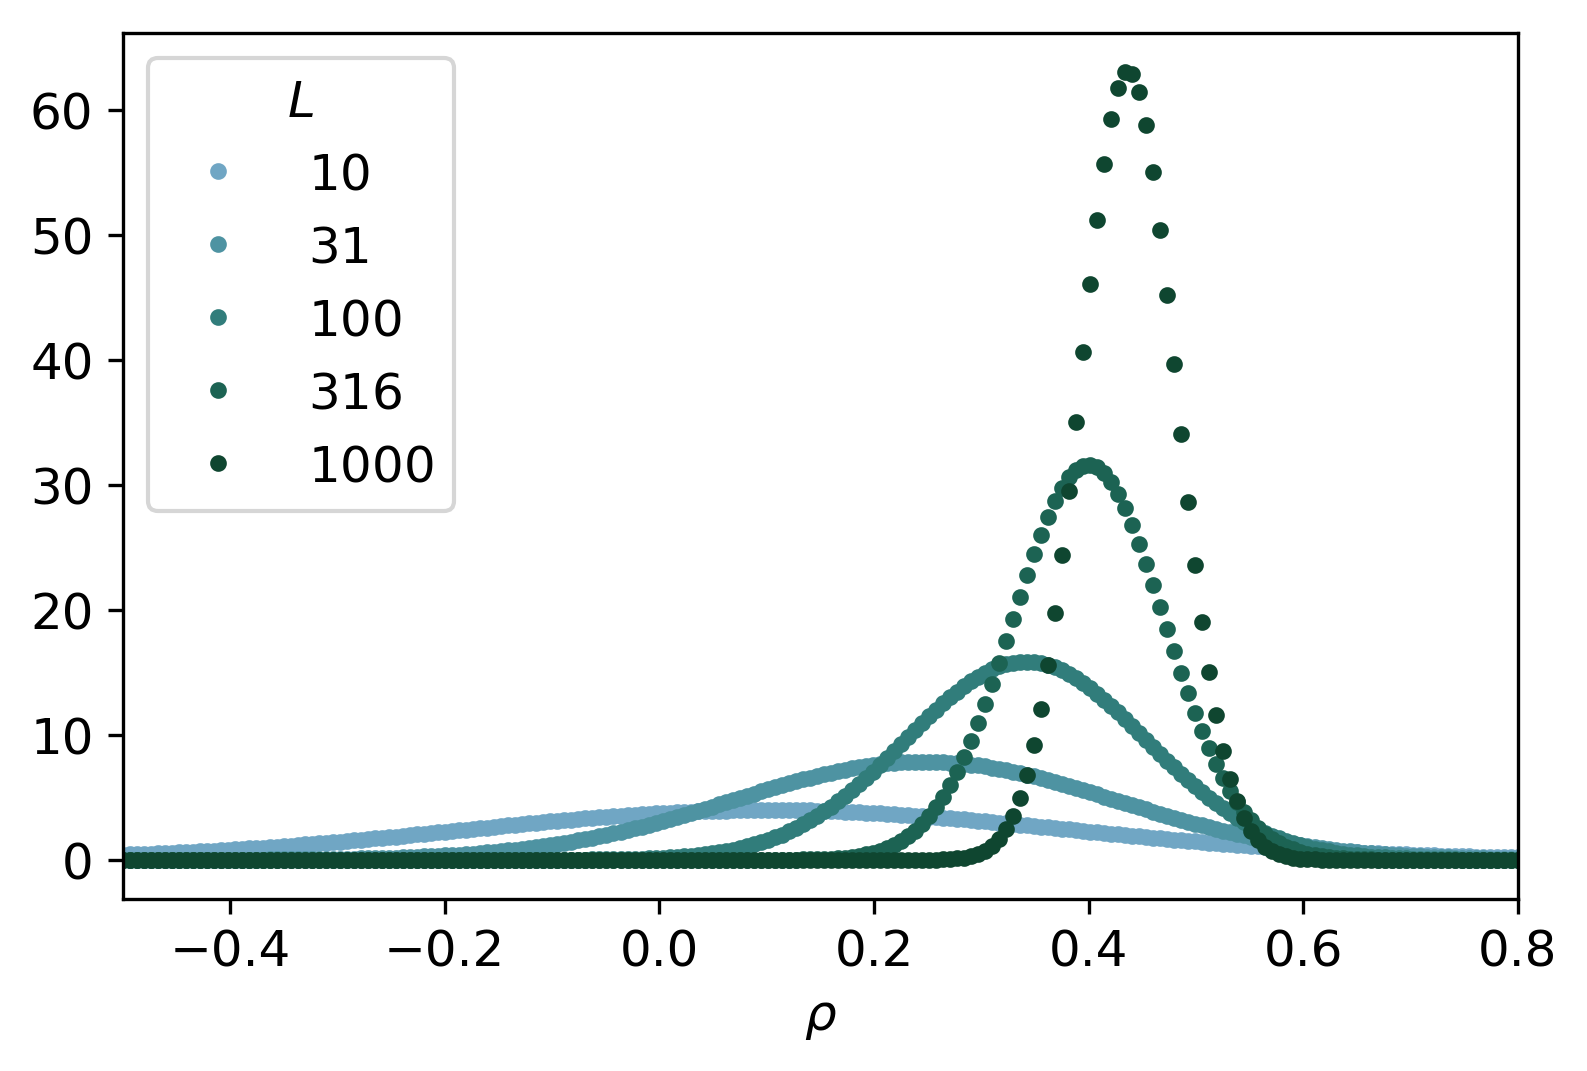

In [13]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', palette))
for l_index, l in enumerate(ls):
    ax.plot(
        rhos, a[l_index, :],
        '.',
        label=r'${}$'.format(l),
        rasterized=True,
    )
ax.set_xbound(rhos.min(), rhos.max())
ax.set_xlabel(r'$\rho$')
ax.legend(title=r'$L$', loc='upper left')
plt.show()

**Figure**: Mocked raw data, precisely sampled from the scaling function and de-scaled.

## Achieving data collapse with the mock data

Our mock data we now want to scale with the **fssa.scaledata** routine.
We compare the quality of the data collapse of several values for the critical exponents, numerically and graphically.

In [14]:
# Put some relative error bars on the precise data
da = a * 0.1

In [15]:
rho_c = np.tile(0.5, (3, 3))
nu = np.tile(2.5, (3, 3))
zeta = np.tile(1.5, (3, 3))
rho_c[0, :] = [0.25, 0.5, 0.75]
nu[1, :] = [2.0, 2.5, 3.0]
zeta[2, :] = [1.0, 1.5, 2.0]

In [16]:
# re-scale data (manually)
scaled_data = list()
quality = list()
for i in range(3):
    my_scaled_data = list()
    my_quality = list()
    for j in range(3):
        my_scaled_data.append(
            fssa.scaledata(
                ls, rhos, a, da,
                rho_c[i, j], nu[i, j], zeta[i, j]
            )
        )
        my_quality.append(fssa.quality(*my_scaled_data[-1]))
    scaled_data.append(my_scaled_data)
    quality.append(my_quality)

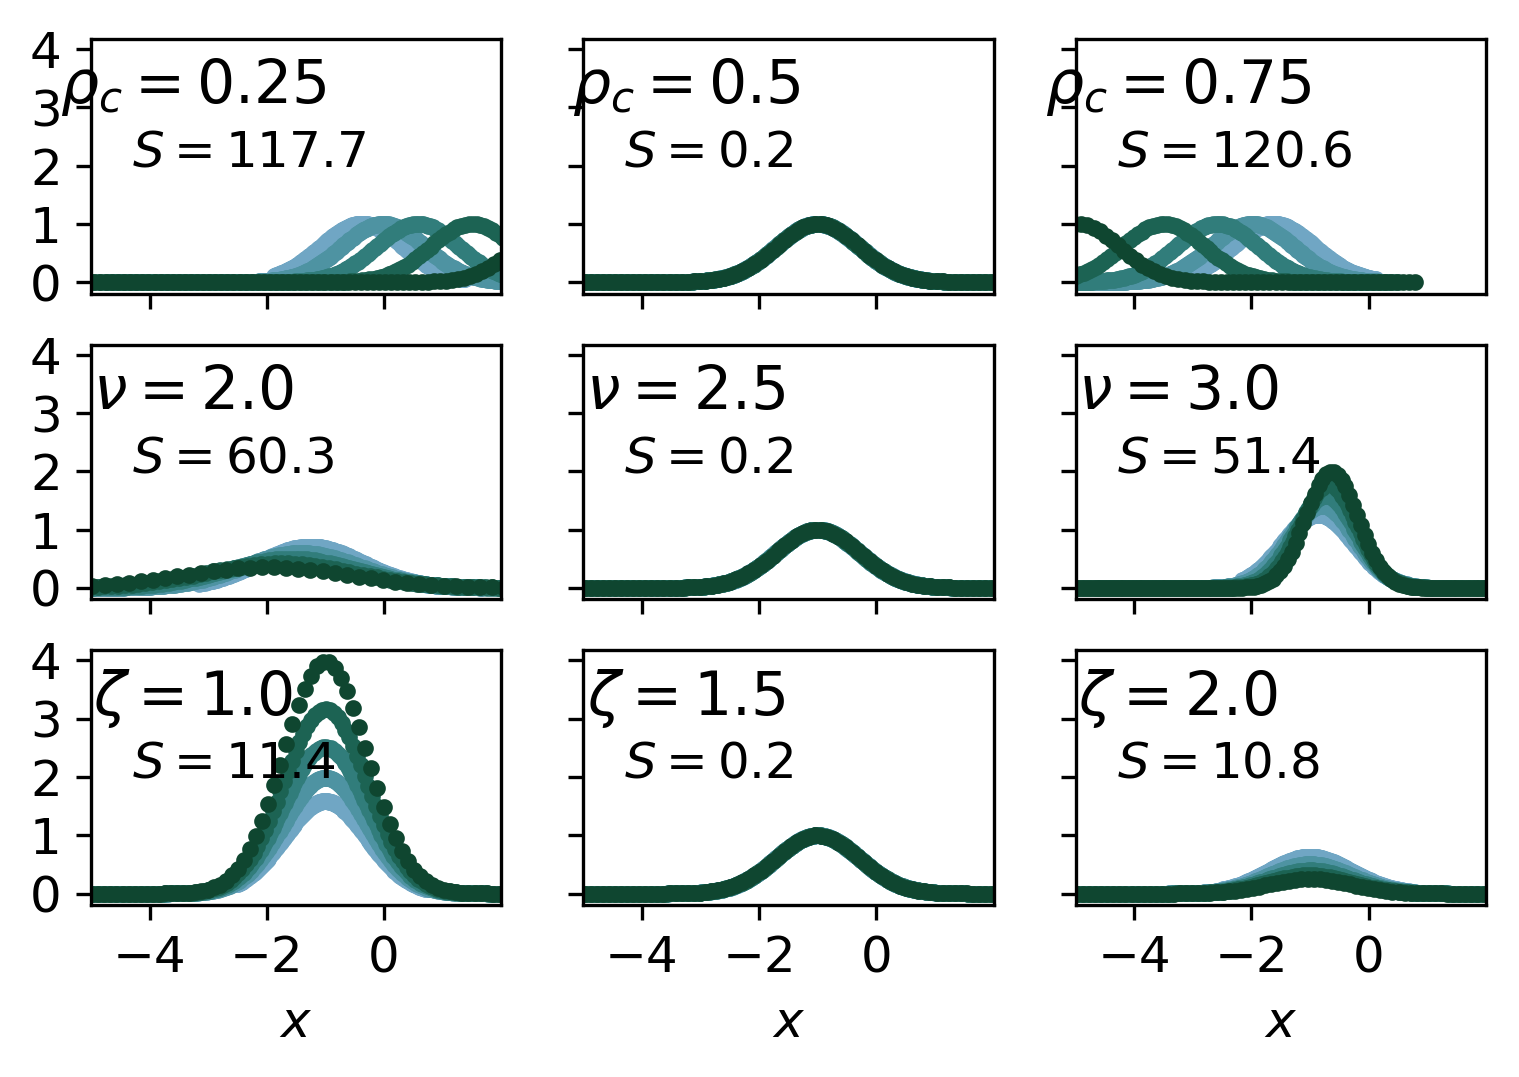

In [17]:
# plot manually re-scaled data
fig, axes = plt.subplots(
    nrows=3, ncols=3, squeeze=True,
    #figsize=(8, 7),
    sharex=True, sharey=True,
)

for (i, j) in itertools.product(range(3), range(3)):
    ax = axes[i, j]
    ax.set_prop_cycle(cycler('color', palette))
    my_scaled_data = scaled_data[i][j]
    for l_index, l in enumerate(ls):
        ax.plot(
            my_scaled_data.x[l_index, :], my_scaled_data.y[l_index, :],
            '.',
            label=r'${}$'.format(l),
            rasterized=True,
        )
    ax.set_xbound(-5, 2)
    if i == 0:
        ax.set_title(
            r'$\rho_c = {}$'.format(rho_c[i, j]),
            position=(0.25, 0.65),
        )
    elif i == 1:
        ax.set_title(
            r'$\nu = {}$'.format(nu[i, j]),
            position=(0.25, 0.65),
        )
    elif i == 2:
        ax.set_title(
            r'$\zeta = {}$'.format(zeta[i, j]),
            position=(0.25, 0.65),
        )
    if i == 2:
        ax.set_xlabel(r'$x$')
        ax.set_xticks([-4, -2, 0, ])
    if j == 0:
        ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.text(
        0.1, 0.5,
        r'$S={:.1f}$'.format(quality[i][j]),
        transform=ax.transAxes,
    )
    
plt.show()

**Figure**: Scaling the mock data with varying exponents. The true exponents are in the middle column as the critical parameter $\rho_c = \frac{1}{2}$ and $\nu = \frac{5}{2}$, $\zeta = \frac{3}{2}$, as signified by the data collapse onto the single master curve and the quality-of-fit $S$ (smaller is better).

## Auto-scaling the mock data

Now that we have an idea of the approximate range of the exponents, we employ the *fssa.autoscale* function to algorithmically determine accurate values and their errors.

In [51]:
ret = fssa.autoscale(ls, rhos, a, da, 0.4, 13, 3)

In [52]:
ret

           dnu: 0.013800624867629636
          drho: 0.002962029264133751
         dzeta: 0.06559046328070221
        errors: array([0.00296203, 0.01380062, 0.06559046])
 final_simplex: (array([[0.49980335, 2.50215157, 1.49559188],
       [0.50025533, 2.50302918, 1.49169546],
       [0.5004355 , 2.50517997, 1.49927841],
       [0.49992527, 2.50080734, 1.50479761]]), array([0.17702209, 0.17756061, 0.17927491, 0.18087554]))
           fun: 0.17702208952570103
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 70
            nu: 2.5021515659724454
           rho: 0.49980335230133555
        status: 0
       success: True
         varco: array([[ 8.77361736e-06,  3.60044251e-05, -2.08168787e-05],
       [ 3.60044251e-05,  1.90457247e-04, -2.30302553e-04],
       [-2.08168787e-05, -2.30302553e-04,  4.30210887e-03]])
             x: array([0.49980335, 2.50215157, 1.49559188])
          zeta: 1.495591878246933

In [53]:
auto_scaled_data = fssa.scaledata(ls, rhos, a, da, ret.rho, ret.nu, ret.zeta)

In [54]:
# critical exponents and errors, quality of data collapse
print(ret.rho, ret.drho)
print(ret.nu, ret.dnu)
print(ret.zeta, ret.dzeta)
print(ret.fun)

0.49980335230133555 0.002962029264133751
2.5021515659724454 0.013800624867629636
1.495591878246933 0.06559046328070221
0.17702208952570103


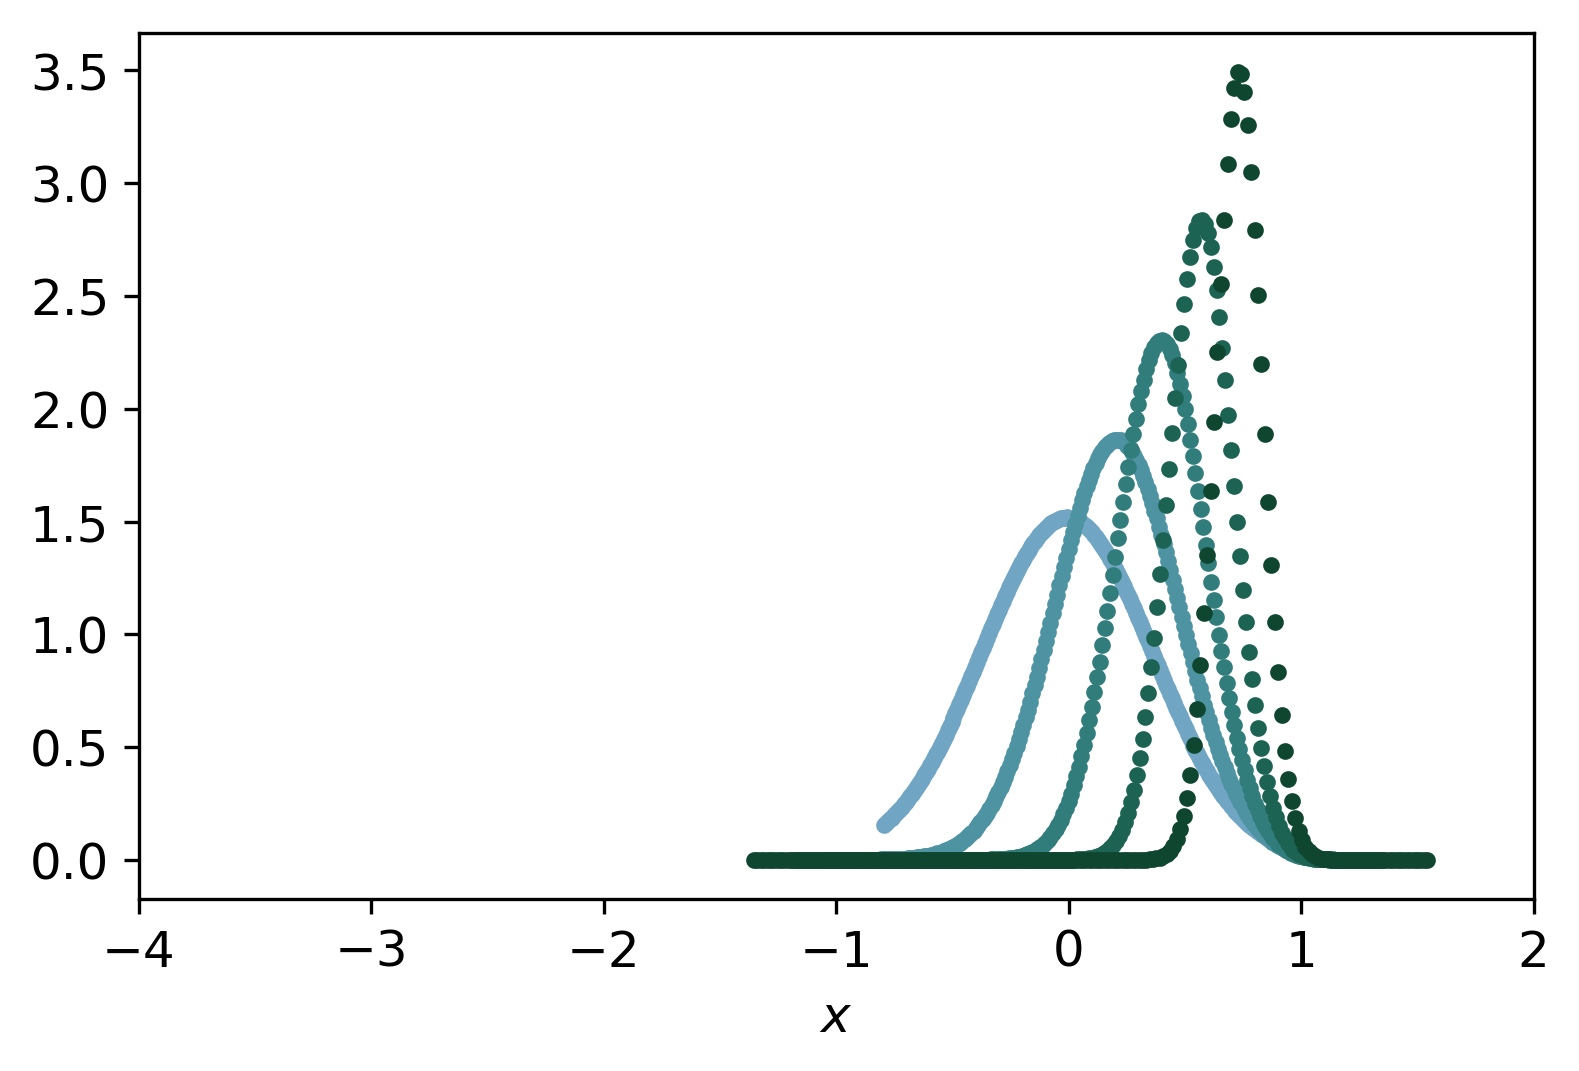

In [42]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', palette))
ax.plot(
    auto_scaled_data.x.T, auto_scaled_data.y.T,
    '.',
)
ax.set_xbound(-4, 2)
ax.set_xlabel(r'$x$')
plt.show()

**Figure**: Auto-scaling with *pyfssa* leads to data collapse of the mock data onto the original scaling function.

## Auto-scaling noisy mock data

In [69]:
noisy_a = a + a * 0.1 * np.random.standard_normal(a.shape)

In [75]:
noisy_ret = fssa.autoscale(ls, rhos, noisy_a, da, 0.4, 2, 1)

In [76]:
noisy_ret

           dnu: 0.038508197125183316
          drho: 0.007693146163198541
         dzeta: 0.1295539501149813
        errors: array([0.00769315, 0.0385082 , 0.12955395])
 final_simplex: (array([[0.50035808, 2.50515471, 1.47660257],
       [0.50033113, 2.50352763, 1.48199334],
       [0.50074106, 2.50633463, 1.48470168],
       [0.50003854, 2.50254423, 1.48644349]]), array([1.21173004, 1.21239779, 1.21553859, 1.21637578]))
           fun: 1.2117300430358786
       message: 'Optimization terminated successfully.'
          nfev: 99
           nit: 55
            nu: 2.5051547146472055
           rho: 0.5003580784033197
        status: 0
       success: True
         varco: array([[ 5.91844979e-05,  2.66350082e-04, -3.26107863e-04],
       [ 2.66350082e-04,  1.48288125e-03, -2.11442407e-03],
       [-3.26107863e-04, -2.11442407e-03,  1.67842260e-02]])
             x: array([0.50035808, 2.50515471, 1.47660257])
          zeta: 1.4766025667252456

In [77]:
noisy_auto_scaled_data = fssa.scaledata(
    ls, rhos, noisy_a, da, noisy_ret.rho, noisy_ret.nu, noisy_ret.zeta
)

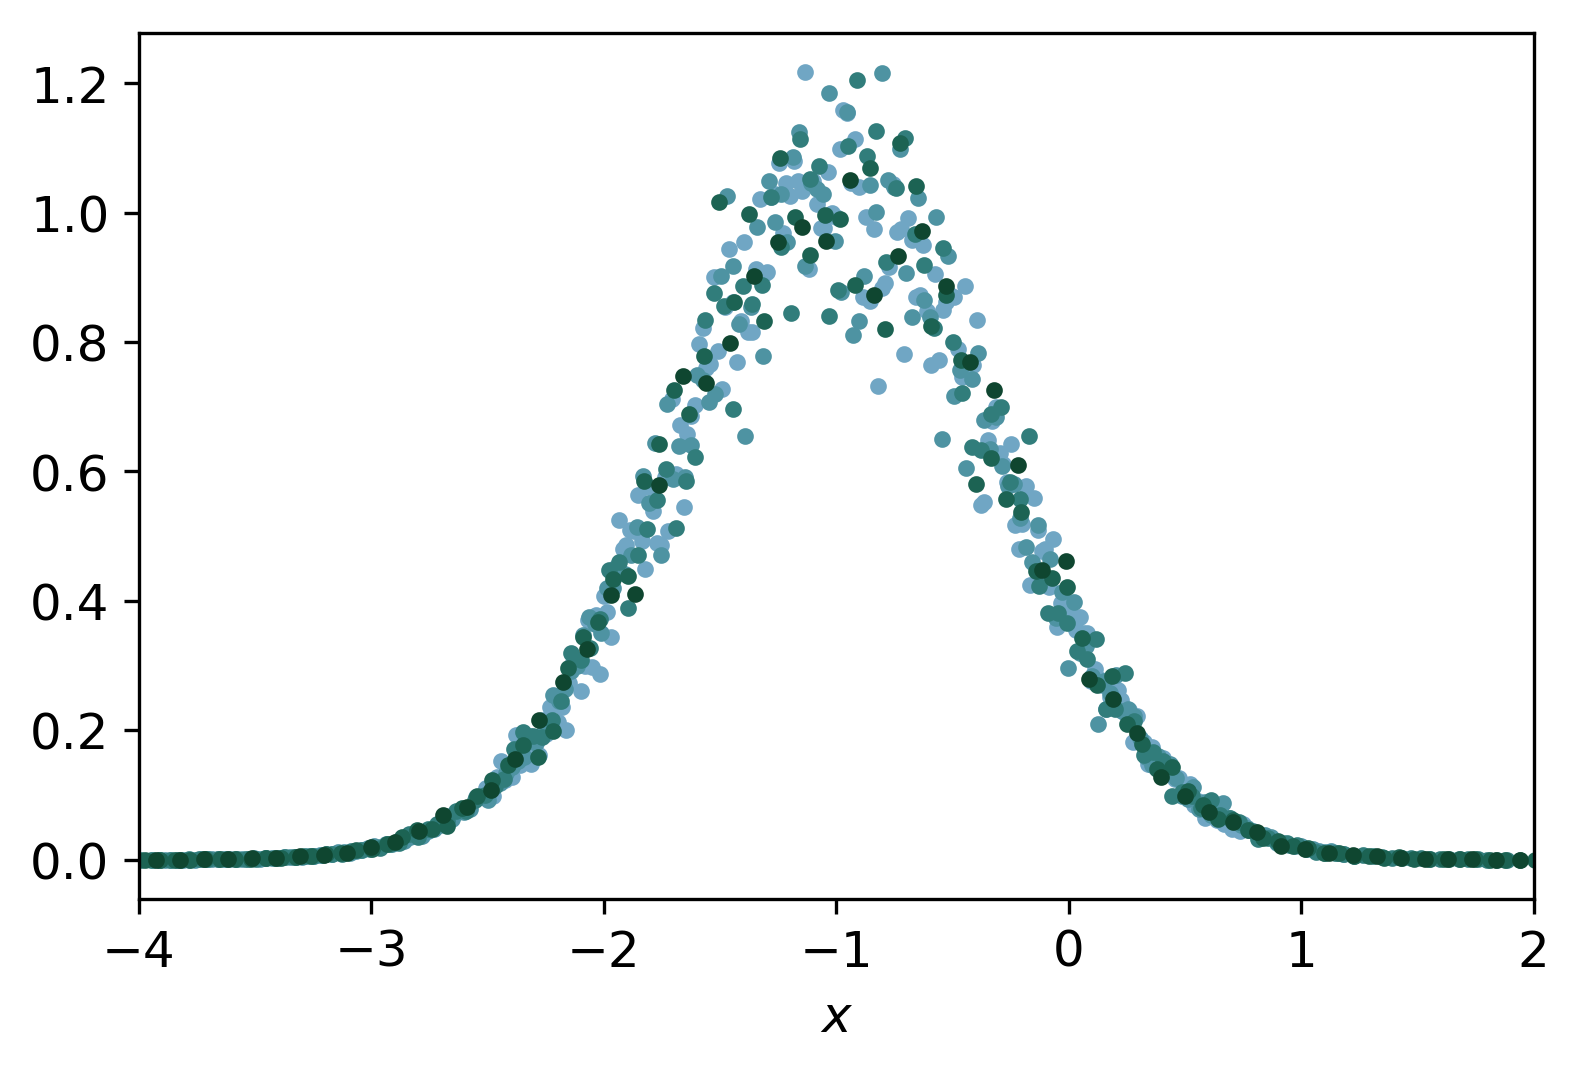

In [78]:
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', palette))
ax.plot(
    noisy_auto_scaled_data.x.T, noisy_auto_scaled_data.y.T,
    '.',
)
ax.set_xbound(-4, 2)
ax.set_xlabel(r'$x$')
plt.show()

**Figure**: Auto-scaling with *pyfssa* leads to data collapse of the noisy mock data onto the original scaling function.

In [79]:
# critical exponents and errors, quality of data collapse
print(noisy_ret.rho, noisy_ret.drho)
print(noisy_ret.nu, noisy_ret.dnu)
print(noisy_ret.zeta, noisy_ret.dzeta)
print(noisy_ret.fun)

0.5003580784033197 0.007693146163198541
2.5051547146472055 0.038508197125183316
1.4766025667252456 0.1295539501149813
1.2117300430358786
